# KAKURO solver 

## with GP

In [1]:
import collections
import random
import numpy
from deap import algorithms, base, creator, tools, gp
import time
import math
import matplotlib.pyplot as plt
import copy
import itertools
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import operator


### Initialize four playing fields with different difficulty levels

In [2]:
easy=[
    ['b',[0,17],[0,16]],
    [[17,0],'w','w'],
    [[16,0],'w','w']
]

medium = [
    ['b',[0,3],[0,9],'b'],
    [[4,0],'w','w',[0,3]],
    [[8,0],'w','w','w'],
    ['b',[3,0],'w','w']
]

# medium = [
#     ['b',[0,15],[0,11],[0,10]],
#     [[23,0],'w','w','w'],
#     [[7,0],'w','w','w'],
#     [[6,0],'w','w','w']
# ]

expert = [
    ['b',[0,7],[0,23],'b','b'],
    [[10,0],'w','w',[0,24],[0,7]],
    [[16,0],'w','w','w','w'],
    [[22,0],'w','w','w','w'],
    ['b','b',[13,0],'w','w']
]

impossible = [
    ['b',[0,13],[0,23],'b',[0,43],[0,5],'b','b'],
    [[17,0],'w','w',[4,0],'w','w','b','b'],
    [[8,0],'w','w',[12,12],'w','w','b','b'],
    [[27,0],'w','w','w','w','b','b','b'],
    ['b','b',[8,0],'w','w',[0,7],'b','b'],
    ['b','b','b',[7,0],'w','w',[0,24],[0,10]],
    ['b','b','b',[28,16],'w','w','w','w'],
    ['b','b',[10,0],'w','w',[9,0],'w','w'],
    ['b','b',[11,0],'w','w',[12,0],'w','w'],
]

### Function for beautiful output

In [3]:
def printMatrix ( matrix): 
    for i in range ( len(matrix) ): 
        for j in range(len(matrix[i]) ): 
            if matrix[i][j]=='b':
                print('|XXXXX|', end = "")
            if matrix[i][j]=='w':
                print('|_____|', end = "")
            if isinstance(matrix[i][j], list):
                print ( "|{:2d}/{:2d}|".format(matrix[i][j][0],matrix[i][j][1]), end = "" )
            if isinstance(matrix[i][j], int):
                print( "|{:4d} |".format(matrix[i][j]), end = "" )
        print ()

### Function for counting empty cells

In [4]:
def count_Spaces(matrix):
    counter=0
    for row in range(len(matrix)):
        for column in range(len(matrix[0])): 
            if matrix[row][column]=='w':
                counter+=1
    return counter 

### Function initializing beginning of the game and difficulty level

In [5]:
def start():
    print('_________Choose level:_________ \n1-Easy \n2-Medium \n3-Hard \n4-Expert')
    a=int(input())
    if a==1:
        matrix=easy
        print('_________You choose easy_________\n') 
        printMatrix ( matrix)
    elif a==2:
        matrix=medium
        print('_________You choose medium_________\n')
        printMatrix ( matrix)
    elif a==3:
        matrix=expert
        print('_________You choose hard_________\n')
        printMatrix ( matrix)  
    elif a==4:
        matrix=impossible
        print('_________You choose expert_________\n')
        printMatrix ( matrix)       
    else:
        print('WRONG') 
    
    countspaces=count_Spaces(matrix)
    print('\n_________Number of spaces {}_________'.format(countspaces))
    print()
    return (matrix,countspaces) 

### To assess Fitness, we will consider the number of duplicate elements vertically and horizontally, as well as the difference in the amounts in the groups (the actual amount minus the amount necessary)

In [6]:
# ____________CHECK_RIGHT_NEIGHBOUR____________________

def check_right(row,column,matrix):
    try:
        if isinstance(matrix[row][column+1], int):
            return True
    except:
        return False
    
# __________________CHECK_DOWN_NEIGHBOUR______________________

def check_down(row,column,matrix):
    try:
        if isinstance(matrix[row+1][column], int):
            return True
    except:
        return False    
    
# _____________COUNT_OF_DUBLICATE_NUMBERS_IN_HORIZONTAL_____________

def check_dubble_hor(matrix):
    counter=0
    for row in range(len(matrix)):
        a=[]
        for column in range(len(matrix[0])):
            if isinstance(matrix[row][column], int):
                a.append(matrix[row][column])
                if check_right(row,column,matrix):
                    continue
                else:
                    z=sum([value-1 for key,value in collections.Counter(a).items() if value>1] )
                    counter+=z
                    a=[]
    return counter                

# ____________COUNT_OF_DUBLICATE_NUMBERS_IN_VERTICAL_________

def check_dubble_vert(matrix):
    counter=0
    for column in range(len(matrix[0])):
        a=[]
        for row in range(len(matrix)):
            if isinstance(matrix[row][column], int):
                a.append(matrix[row][column])
                if check_down(row,column,matrix):
                    continue
                else:
                    z=sum([value-1 for key,value in collections.Counter(a).items() if value>1] )
                    counter+=z
                    a=[]
    return counter   

# _______________DIFFERENCE_IN_SUM_IN_HORIZONTAL_______

def check_sum_hor(matrix):
    counter=0
    for row in range(len(matrix)):
        a=[]
        summ=0
        for column in range(len(matrix[0])):
            if isinstance(matrix[row][column], list):
                summ=matrix[row][column][0]
                continue
            if isinstance(matrix[row][column], int):   
                a.append(matrix[row][column])
                if check_right(row,column,matrix):
                    continue
                else:
                    counter+=abs(sum(a)-summ)
                    a=[]
    return counter    

# ______________DIFFERENCE_IN_SUM_IN_VERTICAL_____________

def check_sum_vert(matrix):
    counter=0
    for column in range(len(matrix[0])):
        a=[]
        summ=0
        for row in range(len(matrix)):
            if isinstance(matrix[row][column], list):
                summ=matrix[row][column][1]
                continue
            if isinstance(matrix[row][column], int):   
                a.append(matrix[row][column])
                if check_down(row,column,matrix):
                    continue
                else:
                    counter+=abs(sum(a)-summ)
                    a=[]
    return counter 

### Function to fill the playing field with data from the tree

In [7]:
def filling_desc(function):
    desc=copy.deepcopy(matrix)
    n=0
    while n<count_spaces:
        step=function(AllCountGroupHor=AllCountGroupHor(desc),
                      AllCountGroupVer=AllCountGroupVer(desc),
                      SumGroupHor=SumGroupHor(desc),
                      SumGroupVer=SumGroupVer(desc),
                      SumNextGroupVerHor=SumNextGroupVerHor(desc),
                      SumNextGroupVerVer=SumNextGroupVerVer(desc),
                      SumNextGroupHorVer=SumNextGroupHorVer(desc),
                      SumNextGroupHorHor=SumNextGroupHorHor(desc),
                      CurrentlySumGroupHor=CurrentlySumGroupHor(desc),
                      CurrentlySumGroupVer=CurrentlySumGroupVer(desc),
                      CurrentlySumNextGroupHorHor=CurrentlySumNextGroupHorHor(desc),
                      CurrentlySumNextGroupHorVer=CurrentlySumNextGroupHorVer(desc),
                      CurrentlySumNextGroupVerHor=CurrentlySumNextGroupVerHor(desc),
                      CurrentlySumNextGroupVerVer=CurrentlySumNextGroupVerVer(desc),
#                       CurrentlySumNextGroup3HorHor=CurrentlySumNextGroup3HorHor(desc),
#                       CurrentlySumNextGroup3HorVer=CurrentlySumNextGroup3HorVer(desc),
#                       CurrentlySumNextGroup3VerHor=CurrentlySumNextGroup3VerHor(desc),
#                       CurrentlySumNextGroup3VerVer=CurrentlySumNextGroup3VerVer(desc),
                      DubbleHor=DubbleHor(desc),
                      DubbleVer=DubbleVer(desc),
                      BalanceStepsHor=ost_group_hor(desc),
                      BalanceStepsVer=ost_group_ver(desc),
                      BalanceStepsNextGroupVerHor=BalanceStepsNextGroupVerHor(desc),
                      BalanceStepsNextGroupVerVer=BalanceStepsNextGroupVerVer(desc),
                      BalanceStepsNextGroupHorHor=BalanceStepsNextGroupHorHor(desc),
                      BalanceStepsNextGroupHorVer=BalanceStepsNextGroupHorVer(desc)
                      
                     )
                        
        if 0<step<10:
            a=False
            for row in range(len(desc)):
                if a:
                    break
                for column in range(len(desc[0])):
                    if desc[row][column]=='w':  
                        desc[row][column]=int(step)
                        a=True
                        break
        else:
            return False
        n+=1                     
    return desc 

### Fitness

In [8]:
def evaluate (tree):
    function=gp.compile(tree,pset)
    desc=filling_desc(function)
    if desc==False:
        return 1000,
    else:
        dubble_hor=check_dubble_hor(desc)
        dubble_vert=check_dubble_vert(desc)
        sum_vert=check_sum_vert(desc)
        sum_hor=check_sum_hor(desc)
        return (sum_hor+sum_vert)+(dubble_vert+dubble_hor)*10,  

### Functions to GP

In [9]:
def protectedDiv(left, right):
    try:
        return int(left / right)
    except ZeroDivisionError:
        return 1  

def if_then_more_else(x1, x2,x3,x4):
    if x1>x2:
        return x3
    else:
        return x4
def vv(x1,x2,x3):
    if x1<x2:
        return x3
    else:
        return 1

def bb(x1,x2,x3,x4,x5,x6):
    if x1>x2 and x3>x4:
        return x5
    elif x1<x2 and x3<x4:
        return x6
    else:
        return 1

def nn(x1,x2,x3):
    if x1>x2:
        return x1+x2-x3
    else: return x1+x2+x3
    
def kk(x1,x2,x3):
    if x1>0:
        return x2
    else: return x3 
    
def hh(x1,x2,x3,x4,x5):
    if x1+x2<x3:
        return x4
    else: return x5    

### Terminals

In [10]:
# _______________TERMINALS___________________  

# ______________COUNTS_OF_HORIZONTAL_GROUP____________________

def AllCountGroupHor(matrix):
    counter=0
    for row in range(len(matrix)):
        for column in range(len(matrix[0])): 
            if isinstance(matrix[row][column], list):
                if matrix[row][column][0]!=0:
                    counter+=1
    return counter 

# ______________COUNTS_OF_VERTICAL_GROUP____________________

def AllCountGroupVer(matrix):
    counter=0
    for row in range(len(matrix)):
        for column in range(len(matrix[0])): 
            if isinstance(matrix[row][column], list):
                if matrix[row][column][1]!=0:
                    counter+=1
    return counter 

# _________________________________________________

def search_hor(matrix,row,column):
    while not isinstance(matrix[row][column], list):
        column-=1
    return matrix[row][column][0]     

def search_ver(matrix,row,column):
    while not isinstance(matrix[row][column], list):
        row-=1
    return matrix[row][column][1]  

# _______________HORIZONTAL_GROUP_AMOUNT______________

def SumGroupHor(matrix):
    a=False
    for row in range(len(matrix)):
        if a==True:
            break
        for column in range(len(matrix[0])): 
            if matrix[row][column]=='w':
                return search_hor(matrix,row,column)
                a=True
                break
            else:
                continue

# _______________VERTICAL_GROUP_AMOUNT______________                
                
def SumGroupVer(matrix):
    a=False
    for row in range(len(matrix)):
        if a==True:
            break
        for column in range(len(matrix[0])): 
            if matrix[row][column]=='w':
                return search_ver(matrix,row,column)
                a=True
                break
            else:
                continue                
                
# ________________________________________________

def sum_in_group_ver(matrix,row,column):
    summ=0
    while not isinstance(matrix[row][column], list):
        if isinstance(matrix[row][column], int):
            summ+=matrix[row][column]
        row-=1
    return summ 
                
# _______________VERTICAL_GROUP_AMOUNT_CURRENTLY______________   

def CurrentlySumGroupVer(matrix):
    a=False
    for row in range(len(matrix)):
        if a==True:
            break
        for column in range(len(matrix[0])): 
            if matrix[row][column]=='w':
                return sum_in_group_ver(matrix,row,column)
                a=True
                break
            else:
                continue                 

                
def sum_in_group_hor(matrix,row,column):
    summ=0
    while not isinstance(matrix[row][column], list):
        if isinstance(matrix[row][column], int):
            summ+=matrix[row][column]
        column-=1
    return summ 

# _______________HORIZONTAL_GROUP_AMOUNT_CURRENTLY______________ 

def CurrentlySumGroupHor(matrix):
    a=False
    for row in range(len(matrix)):
        if a==True:
            break
        for column in range(len(matrix[0])): 
            if matrix[row][column]=='w':
                return sum_in_group_hor(matrix,row,column)
                a=True
                break
            else:
                continue                  

# ____________________________________________

def search_ost_hor(matrix,row,column):
    summ=0
    try:
        while matrix[row][column]=='w':
            summ+=1
            column+=1
    except:
        return summ
    return summ

def search_ost_ver(matrix,row,column):
    summ=0
    try:
        while matrix[row][column]=='w':
            summ+=1
            row+=1
    except:
        return summ
    return summ

# _____________BALANCE_STEPS_IN_HORIZONTAL_GROUP___________________

def ost_group_hor(matrix):
    a=False
    for row in range(len(matrix)):
        if a==True:
            break
        for column in range(len(matrix[0])): 
            if matrix[row][column]=='w':
                return search_ost_hor(matrix,row,column)
                a=True
                break
            else:
                continue

# _____________BALANCE_STEPS_IN_VERTICAL_GROUP___________________                
                
def ost_group_ver(matrix):
    a=False
    for row in range(len(matrix)):
        if a==True:
            break
        for column in range(len(matrix[0])): 
            if matrix[row][column]=='w':
                return search_ost_ver(matrix,row,column)
                a=True
                break
            else:
                continue                

def DubbleHor(matrix):
    counter=0
    for row in range(len(matrix)):
        a=[]
        for column in range(len(matrix[0])):
            if isinstance(matrix[row][column], int):
                a.append(matrix[row][column])
                if check_right(row,column,matrix):
                    continue
                else:
                    z=sum([value-1 for key,value in collections.Counter(a).items() if value>1] )
                    counter+=z
                    a=[]
    return 1 if counter>0 else 0                

# ____________COUNT_OF_DUBLICATE_NUMBERS_IN_VERTICAL_________

def DubbleVer(matrix):
    counter=0
    for column in range(len(matrix[0])):
        a=[]
        for row in range(len(matrix)):
            if isinstance(matrix[row][column], int):
                a.append(matrix[row][column])
                if check_down(row,column,matrix):
                    continue
                else:
                    z=sum([value-1 for key,value in collections.Counter(a).items() if value>1] )
                    counter+=z
                    a=[]
    return 1 if counter>0 else 0  
# ___________________________________________

def BalanceStepsNextGroupHorVer(matrix):
    a=False
    for row in range(len(matrix)):
        if a==True:
            break
        for column in range(len(matrix[0])): 
            if matrix[row][column]=='w':
                try:
                    if matrix[row][column+1]=='w':
                        return search_ost_ver(matrix,row,column+1)
                except:
                    return 0
                else:
                    return 0
                a=True
                break
            else:
                continue
                
def BalanceStepsNextGroupHorHor(matrix):
    a=False
    for row in range(len(matrix)):
        if a==True:
            break
        for column in range(len(matrix[0])): 
            if matrix[row][column]=='w':
                try:
                    if matrix[row][column+1]=='w':
                        return search_ost_hor(matrix,row,column+1)
                except:
                    return 0
                else:
                    return 0
                a=True
                break
            else:
                continue                
                
                
                
def BalanceStepsNextGroupVerVer(matrix):
    a=False
    for row in range(len(matrix)):
        if a==True:
            break
        for column in range(len(matrix[0])): 
            if matrix[row][column]=='w':
                try:
                    if matrix[row+1][column]=='w':
                        return search_ost_ver(matrix,row+1,column)
                except:
                    return 0
                else:
                    return 0
                a=True
                break
            else:
                continue    
                
                
def BalanceStepsNextGroupVerHor(matrix):
    a=False
    for row in range(len(matrix)):
        if a==True:
            break
        for column in range(len(matrix[0])): 
            if matrix[row][column]=='w':
                try:
                    if matrix[row+1][column]=='w':
                        return search_ost_hor(matrix,row+1,column)
                except:
                    return 0
                else:
                    return 0
                a=True
                break
            else:
                continue   
                
def SumNextGroupHorHor(matrix):
    a=False
    for row in range(len(matrix)):
        if a==True:
            break
        for column in range(len(matrix[0])): 
            if matrix[row][column]=='w':
                try:
                    if matrix[row][column+1]=='w':
                        return search_hor(matrix,row,column+1)
                except:
                    return 0
                else:
                    return 0
                a=True
                break
                
            else:
                continue    

def SumNextGroupHorVer(matrix):
    a=False
    for row in range(len(matrix)):
        if a==True:
            break
        for column in range(len(matrix[0])): 
            if matrix[row][column]=='w':
                try:
                    if matrix[row][column+1]=='w':
                        return search_ver(matrix,row,column+1)
                except:
                    return 0
                else:
                    return 0
                a=True
                break
                
            else:
                continue    
                
                
def SumNextGroupVerVer(matrix):
    a=False
    for row in range(len(matrix)):
        if a==True:
            break
        for column in range(len(matrix[0])): 
            if matrix[row][column]=='w':
                try:
                    if matrix[row+1][column]=='w':
                        return search_ver(matrix,row+1,column)
                except:
                    return 0
                else:
                    return 0
                a=True
                break
                
            else:
                continue      
                
                
def SumNextGroupVerHor(matrix):
    a=False
    for row in range(len(matrix)):
        if a==True:
            break
        for column in range(len(matrix[0])): 
            if matrix[row][column]=='w':
                try:
                    if matrix[row+1][column]=='w':
                        return search_hor(matrix,row+1,column)
                except:
                    return 0
                else:
                    return 0
                a=True
                break
                
            else:
                continue    
                
                
                
def CurrentlySumNextGroupHorHor(matrix):
    a=False
    for row in range(len(matrix)):
        if a==True:
            break
        for column in range(len(matrix[0])): 
            if matrix[row][column]=='w':
                try:
                    if matrix[row][column+1]=='w':
                        return sum_in_group_hor(matrix,row,column+1)
                except:
                    return 0
                else:
                    return 0    
                a=True
                break
            else:
                continue      
                
def CurrentlySumNextGroupHorVer(matrix):
    a=False
    for row in range(len(matrix)):
        if a==True:
            break
        for column in range(len(matrix[0])): 
            if matrix[row][column]=='w':
                try:
                    if matrix[row][column+1]=='w':
                        return sum_in_group_ver(matrix,row,column+1)
                except:
                    return 0
                else:
                    return 0    
                a=True
                break
            else:
                continue  
                
def CurrentlySumNextGroupVerHor(matrix):
    a=False
    for row in range(len(matrix)):
        if a==True:
            break
        for column in range(len(matrix[0])): 
            if matrix[row][column]=='w':
                try:
                    if matrix[row+1][column]=='w':
                        return sum_in_group_hor(matrix,row+1,column)
                except:
                    return 0
                else:
                    return 0    
                a=True
                break
            else:
                continue 
                
def CurrentlySumNextGroupVerVer(matrix):
    a=False
    for row in range(len(matrix)):
        if a==True:
            break
        for column in range(len(matrix[0])): 
            if matrix[row][column]=='w':
                try:
                    if matrix[row+1][column]=='w':
                        return sum_in_group_ver(matrix,row+1,column)
                except:
                    return 0
                else:
                    return 0    
                a=True
                break
            else:
                continue                 
def CurrentlySumNextGroupHorHor(matrix):
    a=False
    for row in range(len(matrix)):
        if a==True:
            break
        for column in range(len(matrix[0])): 
            if matrix[row][column]=='w':
                try:
                    if matrix[row][column+1]=='w':
                        return sum_in_group_hor(matrix,row,column+1)
                except:
                    return 0
                else:
                    return 0    
                a=True
                break
            else:
                continue      
                
def CurrentlySumNextGroupHorVer(matrix):
    a=False
    for row in range(len(matrix)):
        if a==True:
            break
        for column in range(len(matrix[0])): 
            if matrix[row][column]=='w':
                try:
                    if matrix[row][column+1]=='w':
                        return sum_in_group_ver(matrix,row,column+1)
                except:
                    return 0
                else:
                    return 0    
                a=True
                break
            else:
                continue  
                
def CurrentlySumNextGroupVerHor(matrix):
    a=False
    for row in range(len(matrix)):
        if a==True:
            break
        for column in range(len(matrix[0])): 
            if matrix[row][column]=='w':
                try:
                    if matrix[row+1][column]=='w':
                        return sum_in_group_hor(matrix,row+1,column)
                except:
                    return 0
                else:
                    return 0    
                a=True
                break
            else:
                continue 
                
def CurrentlySumNextGroupVerVer(matrix):
    a=False
    for row in range(len(matrix)):
        if a==True:
            break
        for column in range(len(matrix[0])): 
            if matrix[row][column]=='w':
                try:
                    if matrix[row+1][column]=='w':
                        return sum_in_group_ver(matrix,row+1,column)
                except:
                    return 0
                else:
                    return 0    
                a=True
                break
            else:
                continue                 
                
                
# +++++++++++++++++++++++++                
                
def CurrentlySumNextGroup3HorHor(matrix):
    a=False
    for row in range(len(matrix)):
        if a==True:
            break
        for column in range(len(matrix[0])): 
            if matrix[row][column]=='w':
                try:
                    if matrix[row][column+2]=='w':
                        return sum_in_group_hor(matrix,row,column+2)
                except:
                    return 0
                else:
                    return 0    
                a=True
                break
            else:
                continue      
                
def CurrentlySumNextGroup3HorVer(matrix):
    a=False
    for row in range(len(matrix)):
        if a==True:
            break
        for column in range(len(matrix[0])): 
            if matrix[row][column]=='w':
                try:
                    if matrix[row][column+2]=='w':
                        return sum_in_group_ver(matrix,row,column+2)
                except:
                    return 0
                else:
                    return 0    
                a=True
                break
            else:
                continue  
                
def CurrentlySumNextGroup3VerHor(matrix):
    a=False
    for row in range(len(matrix)):
        if a==True:
            break
        for column in range(len(matrix[0])): 
            if matrix[row][column]=='w':
                try:
                    if matrix[row+2][column]=='w':
                        return sum_in_group_hor(matrix,row+2,column)
                except:
                    return 0
                else:
                    return 0    
                a=True
                break
            else:
                continue 
                
def CurrentlySumNextGroup3VerVer(matrix):
    a=False
    for row in range(len(matrix)):
        if a==True:
            break
        for column in range(len(matrix[0])): 
            if matrix[row][column]=='w':
                try:
                    if matrix[row+2][column]=='w':
                        return sum_in_group_ver(matrix,row+2,column)
                except:
                    return 0
                else:
                    return 0    
                a=True
                break
            else:
                continue                 
 

### Drawing function

In [11]:
def graf(gen,avg,mn,mx,md):
    fig, ax = plt.subplots(figsize = (14, 8))
    line_avg = ax.plot(gen, avg, label='Average individ')
    line_max = ax.plot(gen, mn, label='Best individ')
    line_min = ax.plot(gen, mx, label='Whorst individ')
    line_md = ax.plot(gen, md, label='Median individ')
    ax.legend()
    plt.xlabel("Generation")
    plt.ylabel("Fitness")
    ax.set_title('''Array \n Mutation probability 0.1% \n Crossover probability 80% \n  
Single point crossover \n One point mutation \n Roulette-wheel sampling''')
    plt.show()

### GP

In [16]:
def ps():
    pset = gp.PrimitiveSet("main", 22)
    pset.addPrimitive(operator.add, 2)
    pset.addPrimitive(operator.sub, 2)
    pset.addPrimitive(operator.mul, 2)
    pset.addPrimitive(protectedDiv, 2)
    pset.addPrimitive(if_then_more_else, 4)

    pset.addPrimitive(vv, 3)
    pset.addPrimitive(bb, 6)
    pset.addPrimitive(nn, 3)
    pset.addPrimitive(kk, 3)
    pset.addPrimitive(hh, 5)

    pset.renameArguments(ARG0="AllCountGroupHor") 
    pset.renameArguments(ARG1="AllCountGroupVer")

    pset.renameArguments(ARG2="SumGroupHor")
    pset.renameArguments(ARG3="SumGroupVer")

    pset.renameArguments(ARG4="CurrentlySumGroupHor")
    pset.renameArguments(ARG5="CurrentlySumGroupVer")

    pset.renameArguments(ARG6="BalanceStepsHor")
    pset.renameArguments(ARG7="BalanceStepsVer")

    pset.renameArguments(ARG8="DubbleHor")
    pset.renameArguments(ARG9="DubbleVer")

    pset.renameArguments(ARG10="BalanceStepsNextGroupHorHor")
    pset.renameArguments(ARG11="BalanceStepsNextGroupHorVer")
    pset.renameArguments(ARG12="BalanceStepsNextGroupVerHor")
    pset.renameArguments(ARG13="BalanceStepsNextGroupVerVer")

    pset.renameArguments(ARG14="SumNextGroupHorHor")
    pset.renameArguments(ARG15="SumNextGroupHorVer")
    pset.renameArguments(ARG16="SumNextGroupVerHor")
    pset.renameArguments(ARG17="SumNextGroupVerVer")

    pset.renameArguments(ARG18="CurrentlySumNextGroupHorHor")
    pset.renameArguments(ARG19="CurrentlySumNextGroupHorVer")
    pset.renameArguments(ARG20="CurrentlySumNextGroupVerHor")
    pset.renameArguments(ARG21="CurrentlySumNextGroupVerVer")

    # pset.renameArguments(ARG22="CurrentlySumNextGroup3HorHor")
    # pset.renameArguments(ARG23="CurrentlySumNextGroup3HorVer")
    # pset.renameArguments(ARG24="CurrentlySumNextGroup3VerHor")
    # pset.renameArguments(ARG25="CurrentlySumNextGroup3VerVer")

    pset.addTerminal(1)
    pset.addTerminal(2)
    pset.addTerminal(3)
    pset.addTerminal(4)
    pset.addTerminal(5)
    pset.addTerminal(6)
    pset.addTerminal(7)
    pset.addTerminal(8)
    pset.addTerminal(9)
    # pset.addTerminal(10)
    # pset.addTerminal(0)
    return pset

pset=ps()

def gp_al(tournsize_n=7,pop=15000):
    creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
    creator.create("Individual", gp.PrimitiveTree, fitness=creator.FitnessMin,pset=pset)
    toolbox = base.Toolbox()
    toolbox.register("expr", gp.genFull, pset=pset, min_=1, max_=4)
    toolbox.register("individual", tools.initIterate, creator.Individual,toolbox.expr)
    toolbox.register("population", tools.initRepeat, list, toolbox.individual)
    toolbox.register("evaluate", evaluate)
    toolbox.register("select", tools.selTournament, tournsize=tournsize_n)
    toolbox.register("mate", gp.cxOnePoint)
    toolbox.register("expr_mut", gp.genFull, min_=1, max_=2)
    toolbox.register("mutate", gp.mutUniform, expr=toolbox.expr_mut, pset=pset)
    pop = toolbox.population(n=pop)
    hof = tools.HallOfFame(1)
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("Average", numpy.mean)
    stats.register("Median", numpy.median)
    stats.register("Min", numpy.min)
    stats.register("Max", numpy.max)
    before = time.time()
    a,v=algorithms.eaSimple(pop, toolbox, 0.7, 0.1,30, stats, halloffame=hof,verbose=False)
    after=time.time() 
    tm=after-before
    avg=v.select("Average")
    md=v.select("Median")
    mn=v.select("Min")
    mx=v.select("Max")
    gen=v.select("gen")
    return(tm,avg,md,mn,mx,gen,hof)

## Game launch and analysis of results

### Attempt 1 = Level Easy

_________Choose level:_________ 
1-Easy 
2-Medium 
3-Hard 
4-Expert
1
_________You choose easy_________

|XXXXX|| 0/17|| 0/16|
|17/ 0||_____||_____|
|16/ 0||_____||_____|

_________Number of spaces 4_________



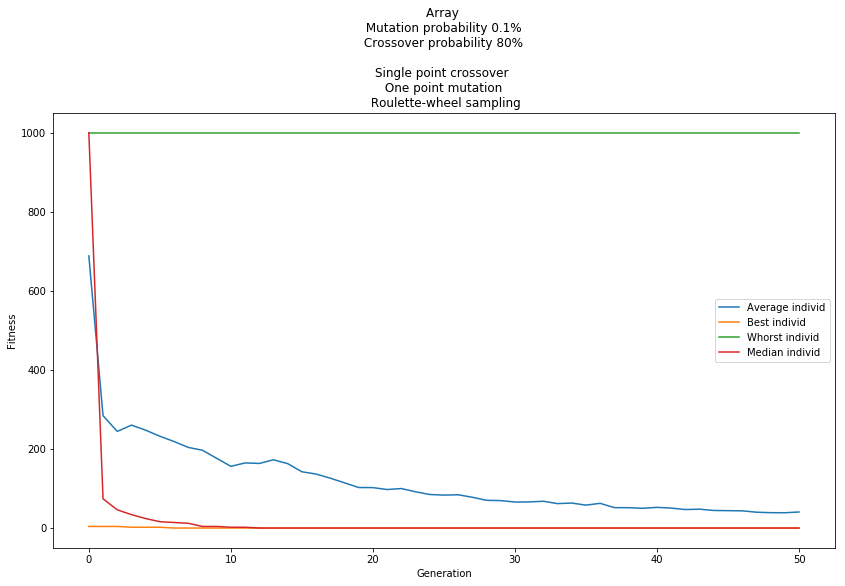

|XXXXX|| 0/17|| 0/16|
|17/ 0||   8 ||   9 |
|16/ 0||   9 ||   7 |

A solution was found in an attemp: 1

Fitness: 0

Optimal strategy: 
 nn(sub(8, BalanceStepsNextGroupHorVer), kk(if_then_more_else(if_then_more_else(2, SumNextGroupVerHor, BalanceStepsHor, BalanceStepsNextGroupVerHor), protectedDiv(SumNextGroupHorVer, AllCountGroupHor), if_then_more_else(BalanceStepsHor, 7, CurrentlySumNextGroupHorVer, SumNextGroupVerVer), kk(BalanceStepsNextGroupVerVer, BalanceStepsNextGroupHorHor, SumGroupHor)), 2, SumNextGroupVerVer), bb(DubbleVer, BalanceStepsHor, CurrentlySumGroupHor, 8, CurrentlySumNextGroupVerVer, DubbleVer))

Algorithms time 216.29183673858643


In [58]:
matrix,count_spaces=start()
attempt=0
n=1
while n!=0:
    attempt+=1
    tm,avg,md,mn,mx,gen,hof=gp_al()
    if evaluate(hof[0])[0]==0:
        graf(gen,avg,mn,mx,md)
        function=gp.compile(hof[0],pset)
        best=filling_desc(function)
        printMatrix(best)
        print()
        print('A solution was found in an attemp: {}'.format(attempt))
        fit=check_sum_hor(best)+check_sum_vert(best)+check_dubble_vert(best)+check_dubble_hor(best)
        print()
        print('Fitness: {}'.format(fit))
        print()
        print('Optimal strategy: \n',str(hof[0]))
        print()
        print('Algorithms time',tm)  
        break



### Attempt 2 = Level Medium

_________Choose level:_________ 
1-Easy 
2-Medium 
3-Hard 
4-Expert
2
_________You choose medium_________

|XXXXX|| 0/ 3|| 0/ 9||XXXXX|
| 4/ 0||_____||_____|| 0/ 3|
| 8/ 0||_____||_____||_____|
|XXXXX|| 3/ 0||_____||_____|

_________Number of spaces 7_________



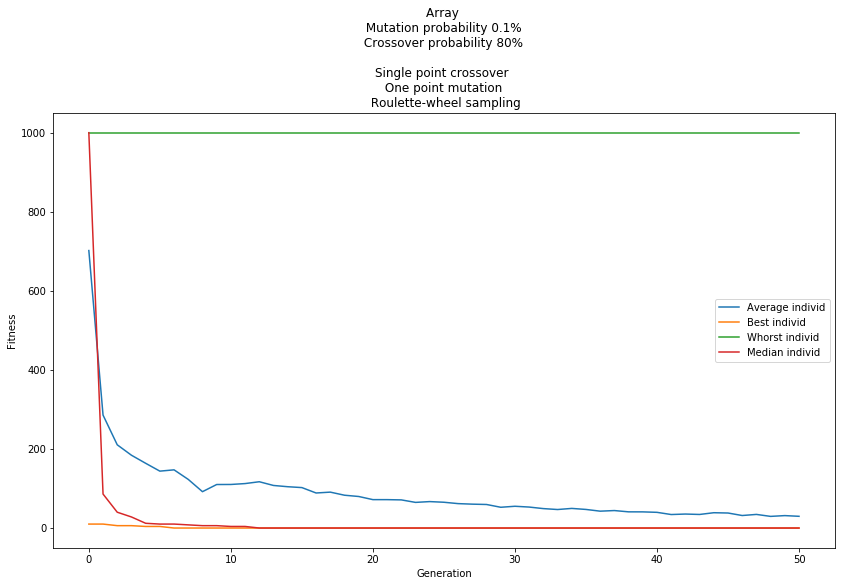

|XXXXX|| 0/ 3|| 0/ 9||XXXXX|
| 4/ 0||   1 ||   3 || 0/ 3|
| 8/ 0||   2 ||   5 ||   1 |
|XXXXX|| 3/ 0||   1 ||   2 |

A solution was found in an attemp: 1

Fitness: 0

Optimal strategy: 
 protectedDiv(nn(bb(vv(BalanceStepsNextGroupHorHor, BalanceStepsNextGroupVerVer, 4), vv(SumNextGroupHorVer, SumGroupHor, CurrentlySumNextGroupHorVer), mul(BalanceStepsHor, BalanceStepsNextGroupVerVer), kk(BalanceStepsVer, 3, 4), bb(SumNextGroupVerVer, CurrentlySumNextGroupHorHor, CurrentlySumNextGroupVerHor, 1, SumGroupHor, DubbleHor), hh(BalanceStepsNextGroupVerVer, 1, CurrentlySumNextGroupHorHor, 3, SumGroupVer)), hh(DubbleHor, SumGroupVer, 5, CurrentlySumGroupVer, 2), CurrentlySumNextGroupHorHor), protectedDiv(2, BalanceStepsNextGroupHorVer))

Algorithms time 297.94906735420227


In [59]:
matrix,count_spaces=start()
attempt=0
n=1
while n!=0:
    attempt+=1
    tm,avg,md,mn,mx,gen,hof=gp_al()
    if evaluate(hof[0])[0]==0:
        graf(gen,avg,mn,mx,md)
        function=gp.compile(hof[0],pset)
        best=filling_desc(function)
        printMatrix(best)
        print()
        print('A solution was found in an attemp: {}'.format(attempt))
        fit=check_sum_hor(best)+check_sum_vert(best)+check_dubble_vert(best)+check_dubble_hor(best)
        print()
        print('Fitness: {}'.format(fit))
        print()
        print('Optimal strategy: \n',str(hof[0]))
        print()
        print('Algorithms time',tm)  
        break

### Attempt 3 = Level Hard

_________Choose level:_________ 
1-Easy 
2-Medium 
3-Hard 
4-Expert
3
_________You choose hard_________

|XXXXX|| 0/ 7|| 0/23||XXXXX||XXXXX|
|10/ 0||_____||_____|| 0/24|| 0/ 7|
|16/ 0||_____||_____||_____||_____|
|22/ 0||_____||_____||_____||_____|
|XXXXX||XXXXX||13/ 0||_____||_____|

_________Number of spaces 12_________



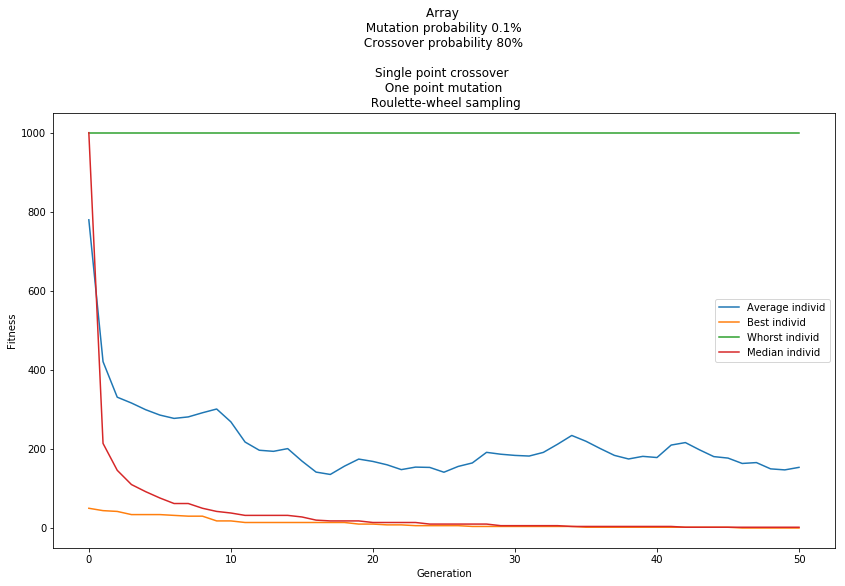

|XXXXX|| 0/ 7|| 0/23||XXXXX||XXXXX|
|10/ 0||   2 ||   8 || 0/24|| 0/ 7|
|16/ 0||   1 ||   6 ||   7 ||   2 |
|22/ 0||   4 ||   9 ||   8 ||   1 |
|XXXXX||XXXXX||13/ 0||   9 ||   4 |

A solution was found in an attemp: 107

Fitness: 0

Optimal strategy: 
 nn(protectedDiv(vv(9, SumGroupVer, hh(CurrentlySumGroupVer, BalanceStepsNextGroupHorHor, mul(BalanceStepsNextGroupHorVer, BalanceStepsNextGroupHorHor), protectedDiv(BalanceStepsNextGroupHorHor, 9), add(8, 7))), nn(if_then_more_else(if_then_more_else(BalanceStepsVer, 2, protectedDiv(protectedDiv(CurrentlySumNextGroupHorHor, BalanceStepsNextGroupHorHor), CurrentlySumGroupVer), 3), SumNextGroupVerHor, BalanceStepsNextGroupHorHor, 8), CurrentlySumGroupVer, DubbleHor)), if_then_more_else(BalanceStepsVer, 1, protectedDiv(protectedDiv(CurrentlySumNextGroupHorHor, BalanceStepsNextGroupHorHor), CurrentlySumGroupVer), 3), vv(9, SumGroupVer, 6))

Algorithms time 353.2214467525482


In [60]:
matrix,count_spaces=start()
attempt=0
n=1
while n!=0:
    attempt+=1
    tm,avg,md,mn,mx,gen,hof=gp_al()
    if evaluate(hof[0])[0]==0:
        graf(gen,avg,mn,mx,md)
        function=gp.compile(hof[0],pset)
        best=filling_desc(function)
        printMatrix(best)
        print()
        print('A solution was found in an attemp: {}'.format(attempt))
        fit=check_sum_hor(best)+check_sum_vert(best)+check_dubble_vert(best)+check_dubble_hor(best)
        print()
        print('Fitness: {}'.format(fit))
        print()
        print('Optimal strategy: \n',str(hof[0]))
        print()
        print('Algorithms time',tm)  
        break

### Attempt 4 = Level Expert

In [ ]:
matrix,count_spaces=start()
attempt=0
n=1
while n!=0:
    attempt+=1
    print(attempt)
    tm,avg,md,mn,mx,gen,hof=gp_al()
    if evaluate(hof[0])[0]==0:
        graf(gen,avg,mn,mx,md)
        function=gp.compile(hof[0],pset)
        best=filling_desc(function)
        printMatrix(best)
        print()
        print('A solution was found in an attemp: {}'.format(attempt))
        fit=check_sum_hor(best)+check_sum_vert(best)+check_dubble_vert(best)+check_dubble_hor(best)
        print()
        print('Fitness: {}'.format(fit))
        print()
        print('Optimal strategy: \n',str(hof[0]))
        print()
        print('Algorithms time',tm)  
        break

_________Choose level:_________ 
1-Easy 
2-Medium 
3-Hard 
4-Expert
4
_________You choose expert_________

|XXXXX|| 0/13|| 0/23||XXXXX|| 0/43|| 0/ 5||XXXXX||XXXXX|
|17/ 0||_____||_____|| 4/ 0||_____||_____||XXXXX||XXXXX|
| 8/ 0||_____||_____||12/12||_____||_____||XXXXX||XXXXX|
|27/ 0||_____||_____||_____||_____||XXXXX||XXXXX||XXXXX|
|XXXXX||XXXXX|| 8/ 0||_____||_____|| 0/ 7||XXXXX||XXXXX|
|XXXXX||XXXXX||XXXXX|| 7/ 0||_____||_____|| 0/24|| 0/10|
|XXXXX||XXXXX||XXXXX||28/16||_____||_____||_____||_____|
|XXXXX||XXXXX||10/ 0||_____||_____|| 9/ 0||_____||_____|
|XXXXX||XXXXX||11/ 0||_____||_____||12/ 0||_____||_____|

_________Number of spaces 28_________

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
